In [7]:
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from skimage.draw import polygon
import numpy as np
import plistlib
PATH = "/mnt/d/Datasets/INbreast/INbreast/INbreast_Release_1.0/"
ROI_PATH = PATH + "AllXML/"
IMG_PATH = PATH + "AllDICOMs/"

gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [85]:
def load_mask(mask_path, imshape=(4084, 3328)):
    """
    This function loads a osirix xml region as a binary numpy array for INBREAST
    dataset
    @mask_path : Path to the xml file
    @imshape : The shape of the image as an array e.g. [4084, 3328]
    return: numpy array where positions in the roi are assigned a value of 1.
    """

    mask = np.zeros(imshape)
    with open(mask_path, 'rb') as mask_file:
        plist_dict = plistlib.load(mask_file, fmt=plistlib.FMT_XML)['Images'][0]
        numRois = plist_dict['NumberOfROIs']
        rois = plist_dict['ROIs']
        assert len(rois) == numRois
        for roi in rois:
            numPoints = roi['NumberOfPoints']
            points = roi['Point_px']
            assert numPoints == len(points)
            points = [eval(point) for point in points]
            if len(points) <= 2:
                for point in points:
                    mask[int(point[1]), int(point[0])] = 1
            else:
                x, y = zip(*points)
                col, row = np.array(x), np.array(y) ##x coord is the column coord in an image and y is the row
                poly_x, poly_y = polygon(row, col, shape=imshape)
                mask[poly_x, poly_y] = 1
    return mask

#Reference from https://gist.github.com/Feyn-Man/de6f62997d051fc6ff75a6aa968537f5, Accessed on 12/1/2023


[(3196.290039, 1048.599976), (3203.560059, 1046.170044), (3211.330078, 1042.780029), (3219.090088, 1037.439941), (3226.850098, 1031.619995), (3233.149902, 1024.339966), (3240.919922, 1017.549988), (3248.679932, 1011.23999), (3255.949951, 1007.849976), (3264.389893, 1007.849976), (3271.649902, 1008.859985), (3279.449951, 1013.390015), (3284.570068, 1019.48999), (3286.030029, 1027.25), (3287.47998, 1034.530029), (3287.47998, 1042.290039), (3285.060059, 1050.050049), (3283.120117, 1057.810059), (3281.659912, 1065.089966), (3280.689941, 1072.359985), (3280.209961, 1080.130005), (3280.209961, 1087.890015), (3276.330078, 1095.650024), (3268.560059, 1100.97998), (3261.77002, 1108.75), (3269.050049, 1115.050049), (3276.810059, 1115.050049), (3284.570068, 1115.050049), (3292.820068, 1115.050049), (3300.100098, 1114.569946), (3307.370117, 1114.569946), (3314.48999, 1116.650024), (3320.469971, 1122.329956), (3326.77002, 1130.089966), (3327.73999, 1137.849976), (3327.73999, 1145.609985), (3327.739

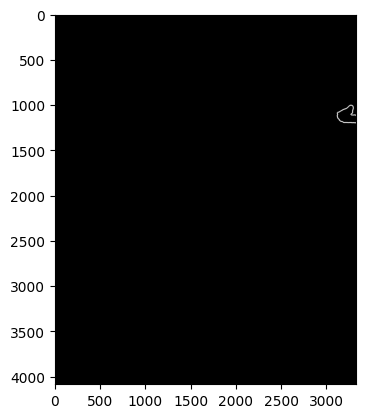

In [80]:

# To load largest ROI in XML file
mask = np.zeros((4084,3328))
with open(ROI_PATH + "20586908.xml", 'rb') as mask_file:
    plist_dict = plistlib.load(mask_file, fmt=plistlib.FMT_XML)['Images'][0]
    numRois = plist_dict['NumberOfROIs']
    rois = plist_dict['ROIs']
    assert len(rois) == numRois
    prevPoints = 0
    for roi in rois:
        numPoints = roi['NumberOfPoints']
        points = roi['Point_px']
        assert numPoints == len(points)
        points = [eval(point) for point in points]
        if numPoints > prevPoints:
            point = points
            prevPoints = numPoints
    for x in point:
        mask[int(x[1])-5:int(x[1])+5, int(x[0])-5:int(x[0])+5] = 1

plt.imshow(mask, cmap='gray')

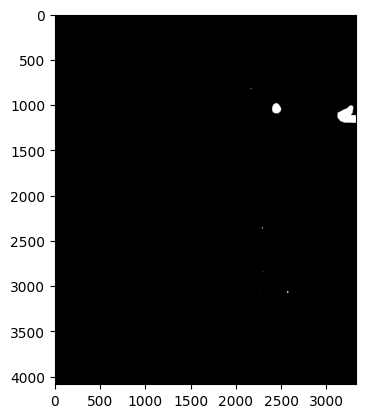

In [86]:
Test_box = load_mask(ROI_PATH + "20586908.xml")
# ret,thresh = cv2.threshold(Test_box,127,255,0)
# contours, _ = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
# x,y,w,h = cv2.boundingRect(contours[0])
# img = cv2.rectangle(Test_box,(x,y),(x+w,y+h),(0,255,0),2)
plt.imshow(Test_box, cmap='gray')